In [1]:
__author__ = "konwar.m"
__copyright__ = "Copyright 2022, AI R&D"
__credits__ = ["konwar.m"]
__license__ = "Individual Ownership"
__version__ = "1.0.1"
__maintainer__ = "konwar.m"
__email__ = "rickykonwar@gmail.com"
__status__ = "Development"

### Importing Libraries

In [2]:
import os
import copy
import time
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from tqdm import tqdm

from numpy import sqrt 
from sklearn.metrics import mean_squared_error

c:\Users\manash.jyoti.konwar\Documents\AI_Random_Projects\virtualEnvs\MLPricingVenv\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
os.chdir('..')
os.getcwd()

'c:\\Users\\manash.jyoti.konwar\\Documents\\AI_Random_Projects\\ML-Retail-Sales'

### Utility Functions

#### Saving / Loading dataframe with dtypes

In [4]:
def to_csv(df, path):
    # Prepend dtypes to the top of df
    df2 = df.copy()
    df2.loc[-1] = df2.dtypes
    df2.index = df2.index + 1
    df2.sort_index(inplace=True)
    # Then save it to a csv
    df2.to_csv(path, index=False)

def read_csv(path):
    # Read types first line of csv
    dtypes = {key:value for (key,value) in pd.read_csv(path,    
              nrows=1).iloc[0].to_dict().items() if 'date' not in value}

    parse_dates = [key for (key,value) in pd.read_csv(path, 
                   nrows=1).iloc[0].to_dict().items() if 'date' in value]
    # Read the rest of the lines with the types from above
    return pd.read_csv(path, dtype=dtypes, parse_dates=parse_dates, skiprows=[1])

### Loading Training Data and Features

In [5]:
finalized_train_dict, finalized_test_dict = {}, {}

In [6]:
train_test_path = r'datasets\train_test_datasets_v02'
files = os.listdir(train_test_path)

training_files = [i for i in files if i.endswith('.csv') and i.startswith('train')]
testing_files = [i for i in files if i.endswith('.csv') and i.startswith('test')]

with open(os.path.join('datasets', 'train_test_datasets_v02', 'parent_cat_map.pkl'), "rb") as fp:
    parent_category_map = pickle.load(fp)

parent_category_inv_map = {v: k for k, v in parent_category_map.items()}

In [7]:
parent_category_inv_map

{0: 'Accessories',
 1: 'Android Games',
 2: 'Books',
 3: 'Cinema',
 4: 'Clean Media (Piece)',
 5: 'Clean Media (Spire)',
 6: 'Delivery Of Goods',
 7: 'Film',
 8: 'Games',
 9: 'Gaming Consoles',
 10: 'Gifts',
 11: 'Mac Games',
 12: 'Music',
 13: 'Pc',
 14: 'Pc Games',
 15: 'Payment Cards (Cinema, Music, Games)',
 16: 'Payment Cards',
 17: 'Power Elements',
 18: 'Programs',
 19: 'Service',
 20: 'Tickets (Digit)',
 21: 'Игры'}

In [8]:
for train_file in tqdm(training_files, desc='Loading training files'):
    finalized_train_dict[parent_category_inv_map.get(int(train_file.split('_')[1]))] = read_csv(os.path.join('datasets','train_test_datasets_v02',train_file))

for test_file in tqdm(testing_files, desc='Loading testing files'):
    finalized_test_dict[parent_category_inv_map.get(int(train_file.split('_')[1]))] = read_csv(os.path.join('datasets','train_test_datasets_v02',test_file))    

Loading testing files: 100%|██████████| 21/21 [00:02<00:00,  9.73it/s]


### Extracting possible uniques

Getting list of possible values for item_category_id, item_id and shop_id used across parent categories for training purpose

In [9]:
unique_dict={
                'parent_category_names':list(finalized_train_dict.keys()),
                'item_id':[],
                'item_category_id':[],
                'shop_id':[]
            }
for parent_cat in tqdm(finalized_train_dict.keys(), desc='Extracting unique ids'):
    parent_data = finalized_train_dict.get(parent_cat) 
    
    unique_item_list = [item_id for item_id in sorted(list(parent_data.item_id.unique())) if item_id not in unique_dict['item_id']]
    unique_dict['item_id'] += unique_item_list

    unique_item_category_list = [item_cat_id for item_cat_id in sorted(list(parent_data.item_category_id.unique())) if item_cat_id not in unique_dict['item_category_id']]
    unique_dict['item_category_id'] += unique_item_category_list

    unique_shop_list = [shop_id for shop_id in sorted(list(parent_data.shop_id.unique())) if shop_id not in unique_dict['shop_id']]
    unique_dict['shop_id'] += unique_shop_list
    
for id_key in copy.deepcopy(unique_dict).keys():
    unique_dict[id_key] = sorted(copy.deepcopy(unique_dict).get(id_key))

print('Total parent categories: %s' %(str(len(unique_dict.get('parent_category_names')))))
print('Total item ids: %s' %(str(len(unique_dict.get('item_id')))))
print('Total item category ids: %s' %(str(len(unique_dict.get('item_category_id')))))
print('Total shop ids: %s' %(str(len(unique_dict.get('shop_id')))))


Extracting unique ids: 100%|██████████| 21/21 [00:05<00:00,  3.71it/s]


Total parent categories: 21
Total item ids: 19986
Total item category ids: 75
Total shop ids: 60


### Preparing baseline data

In [10]:
def prepare_data(**kwargs):
    train_test_data = kwargs.get('train_test_data')
    baseline_features = kwargs.get('baseline_features')
    group_name, group_id = kwargs.get('group_info').get('group_name'), kwargs.get('group_info').get('group_id')

    # Extracting dynamic price ratio features
    item_category_features = list(train_test_data.columns)[list(train_test_data.columns).index('priceratio_parent_category')+1:]

    # Overall features
    baseline_features = baseline_features[:-1] + item_category_features + [baseline_features[-1]]

    # Extracting dtypes
    dtype_features = list(train_test_data[baseline_features[:-1]].copy().dtypes)

    # For training: rows having date_block_num from 0 to 31 is utilized for training the model
    train_time_range_lo = (train_test_data['date_block_num'] >= 0)
    train_time_range_hi =  (train_test_data['date_block_num'] <= 32)

    # For validation: rows having date_block_num as 33
    validation_time =  (train_test_data['date_block_num'] == 33)

    # Retrieve rows for train set, val set, test set
    cv_trainset = train_test_data[train_time_range_lo & train_time_range_hi]
    cv_valset = train_test_data[validation_time]
    cv_trainset = cv_trainset[baseline_features]
    cv_valset = cv_valset[baseline_features]

    print('Extracting training data started')
    # Prepare numpy arrays for training/val/test
    cv_trainset_vals = cv_trainset.values.astype(float)
    trainx = cv_trainset_vals[:, 0:len(baseline_features) - 1]
    trainy = cv_trainset_vals[:, len(baseline_features) - 1]
    print('Extracting training data ended')

    print('Extracting validation data started')
    cv_valset_vals = cv_valset.values.astype(float)
    valx = cv_valset_vals[:, 0:len(baseline_features) - 1]
    valy = cv_valset_vals[:, len(baseline_features) - 1]
    print('Extracting validation data ended')

    print('Extracting features dataframe started')
    df_features = pd.DataFrame(baseline_features[:-1], columns=['feature_name'])
    df_features['group_name'] = group_name
    df_features['group_id'] = group_id
    print('Extracting features dataframe ended')

    return trainx, trainy, valx, valy, df_features, dtype_features

In [11]:
baseline_features = ['date_block_num', 'item_id', 'shop_id', 'item_price', 'item_category_id', 
    'count_item_week_shop', 'price_mean_week_category', 'price_lag_item_1', 'price_lag_item_4', 'price_lag_item_12', 
    'price_lag_item_24', 'price_lag_item_shop_1', 'price_lag_item_shop_4', 'price_lag_item_shop_12', 'price_lag_item_shop_24', 
    'week_block_num', 'month', 'seasonal_index', 'priceratio_parent_category', 'item_cnt_day']

finalized_modelling_dict = {}

for parent_cat in finalized_train_dict.keys():
    print(parent_cat)

    train_x_w_price, train_y_w_price, val_x_w_price, val_y_w_price, df_features, dtype_features = prepare_data(
                                                                                                    train_test_data=finalized_train_dict.get(parent_cat),
                                                                                                    baseline_features=baseline_features,
                                                                                                    group_info={'group_name':parent_cat, 'group_id':parent_category_map.get(parent_cat)},
                                                                                                )
    if parent_cat not in finalized_modelling_dict.keys():
        finalized_modelling_dict[parent_cat] = {
                                                'train_x': train_x_w_price,
                                                'train_y': train_y_w_price,
                                                'val_x': val_x_w_price,
                                                'val_y': val_y_w_price,
                                                'features_df': df_features,
                                                'features_dtype': dtype_features
                                            }
    print(train_x_w_price.shape, train_y_w_price.shape, val_x_w_price.shape, val_y_w_price.shape, df_features.shape)

Accessories
Extracting training data started
Extracting training data ended
Extracting validation data started
Extracting validation data ended
Extracting features dataframe started
Extracting features dataframe ended
(43576, 24) (43576,) (1121, 24) (1121,) (24, 3)
Gifts
Extracting training data started
Extracting training data ended
Extracting validation data started
Extracting validation data ended
Extracting features dataframe started
Extracting features dataframe ended
(155946, 26) (155946,) (5268, 26) (5268,) (26, 3)
Mac Games
Extracting training data started
Extracting training data ended
Extracting validation data started
Extracting validation data ended
Extracting features dataframe started
Extracting features dataframe ended
(7, 20) (7,) (1, 20) (1,) (20, 3)
Music
Extracting training data started
Extracting training data ended
Extracting validation data started
Extracting validation data ended
Extracting features dataframe started
Extracting features dataframe ended
(368381, 2

### Extracting features dataframe

#### Forming base features dataframe

In [12]:
df_features = pd.DataFrame()

if len(finalized_modelling_dict.keys())>0:
    for parent_cat in tqdm(finalized_modelling_dict.keys(), desc='Generating features dataframe'):
        df_features =  pd.concat([finalized_modelling_dict.get(parent_cat).get('features_df'), pd.DataFrame(finalized_modelling_dict.get(parent_cat).get('features_dtype'), columns=['feature_dtype'])], axis=1) if df_features.shape[0] == 0 \
                        else pd.concat([df_features, pd.concat([finalized_modelling_dict.get(parent_cat).get('features_df'), pd.DataFrame(finalized_modelling_dict.get(parent_cat).get('features_dtype'), columns=['feature_dtype'])], axis=1)], ignore_index=True).reset_index(drop=True)

df_features

Generating features dataframe: 100%|██████████| 21/21 [00:00<00:00, 420.66it/s]


,feature_name,group_name,group_id,feature_dtype
0,date_block_num,Accessories,0,int64
1,item_id,Accessories,0,int64
2,shop_id,Accessories,0,int64
3,item_price,Accessories,0,float64
4,item_category_id,Accessories,0,int64
...,...,...,...,...
469,priceratio_item_category_39,Gaming Consoles,9,float64
470,priceratio_item_category_40,Gaming Consoles,9,float64
471,priceratio_item_category_41,Gaming Consoles,9,float64
472,priceratio_item_category_42,Gaming Consoles,9,float64


#### Adding feature types

In [13]:
df_features = df_features.drop(columns=['feature_type']) if 'feature_type' in df_features.columns else df_features
df_features['feature_type'] = np.nan

for row_index, row_data in df_features.copy().iterrows():
    feature_list = row_data.feature_name.split('_') 
    
    feature_type = 'generic'
    if 'id' in feature_list:
        feature_type = 'id'
    elif 'price' in feature_list and 'lag' in feature_list:
        feature_type = 'lag price'
    elif 'price' in feature_list:
        feature_type = 'price'
    elif 'priceratio' in feature_list:
        feature_type = 'price ratio'
    elif 'seasonal' in feature_list:
        feature_type = 'seasonality'
    
    df_features.iloc[row_index, df_features.columns.get_loc('feature_type')] = feature_type

df_features

,feature_name,group_name,group_id,feature_dtype,feature_type
0,date_block_num,Accessories,0,int64,generic
1,item_id,Accessories,0,int64,id
2,shop_id,Accessories,0,int64,id
3,item_price,Accessories,0,float64,price
4,item_category_id,Accessories,0,int64,id
...,...,...,...,...,...
469,priceratio_item_category_39,Gaming Consoles,9,float64,price ratio
470,priceratio_item_category_40,Gaming Consoles,9,float64,price ratio
471,priceratio_item_category_41,Gaming Consoles,9,float64,price ratio
472,priceratio_item_category_42,Gaming Consoles,9,float64,price ratio


### Extracting xvar dataframe

#### Generating xvar from train data for each parent category

In [14]:
df_unique_feature = df_features.drop_duplicates(['feature_name','feature_dtype']).reset_index(drop=True)
feature_dict = {row_data.feature_name: row_data.feature_dtype.name for row_data in df_unique_feature.itertuples()}

In [15]:
df_xvar = pd.DataFrame(columns=list(feature_dict.keys()))
df_xvar = df_xvar.astype(dtype=feature_dict)
df_xvar.dtypes

date_block_num                   int64
item_id                          int64
shop_id                          int64
item_price                     float64
item_category_id                 int64
                                ...   
priceratio_item_category_39    float64
priceratio_item_category_40    float64
priceratio_item_category_41    float64
priceratio_item_category_42    float64
priceratio_item_category_43    float64
Length: 94, dtype: object

In [16]:
counter=1
for parent_cat in finalized_train_dict.keys():
    print(parent_cat)
    latest_parent_xvar = finalized_train_dict.get(parent_cat).sort_values('date_block_num').groupby(['shop_id','item_id','item_category_id']).tail(1).reset_index(drop=True)
    df_xvar = pd.concat([df_xvar, latest_parent_xvar], ignore_index=True).reset_index(drop=True)
    counter+=1

Accessories
Gifts
Mac Games
Music
Pc
Pc Games
Payment Cards (Cinema, Music, Games)
Payment Cards
Power Elements
Programs
Service
Android Games
Tickets (Digit)
Игры
Books
Cinema
Clean Media (Piece)
Clean Media (Spire)
Film
Games
Gaming Consoles


In [17]:
df_xvar

,date_block_num,item_id,shop_id,item_price,item_category_id,count_item_week_shop,price_mean_week_category,price_lag_item_1,price_lag_item_4,price_lag_item_12,...,priceratio_item_category_37,priceratio_item_category_38,priceratio_item_category_39,priceratio_item_category_40,priceratio_item_category_41,priceratio_item_category_42,priceratio_item_category_43,week_start_date,item_cnt_day,parent_category_name
0,0,5588,14,149.0,6,1.0,149.00,149.0,0.000,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-01-14,1.0,Accessories
1,0,5588,12,149.0,6,2.0,669.50,149.0,0.000,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-01-14,1.0,Accessories
2,0,5584,7,248.0,6,2.0,423.50,236.0,0.000,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-01-14,1.0,Accessories
3,0,5601,0,412.0,6,6.0,1056.25,539.1,0.000,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-01-14,1.0,Accessories
4,0,7889,45,12490.0,4,6.0,3751.80,0.0,0.000,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-01-14,1.0,Accessories
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393942,33,12118,28,18991.0,42,2.0,20741.00,0.0,22990.000,0.000,...,1.993,0.622,NaN,NaN,1.056,0.831,NaN,2015-10-05,1.0,Gaming Consoles
393943,33,13407,28,22491.0,42,2.0,20741.00,23641.0,25990.000,27989.750,...,2.360,0.737,NaN,NaN,1.250,0.985,NaN,2015-10-05,1.0,Gaming Consoles
393944,33,7982,37,21991.0,42,1.0,21991.00,22991.0,25989.667,25989.875,...,2.308,0.721,NaN,NaN,1.222,0.963,NaN,2015-10-05,1.0,Gaming Consoles
393945,33,13405,53,20999.0,42,2.0,21699.00,0.0,0.000,0.000,...,2.204,0.688,NaN,NaN,1.167,0.919,NaN,2015-10-05,1.0,Gaming Consoles


### Data Evaluation

In [18]:
df_exploration_data = finalized_train_dict.get('Accessories').sort_values(by='item_price')
df_exploration_data

,week_start_date,date_block_num,item_id,shop_id,item_price,item_cnt_day,item_category_id,parent_category_name,count_item_week_shop,price_mean_week_category,...,price_lag_item_shop_24,week_block_num,month,seasonal_index,priceratio_parent_category,priceratio_item_category_2,priceratio_item_category_3,priceratio_item_category_4,priceratio_item_category_5,priceratio_item_category_6
15979,2014-02-10,13,5681,22,22.0,1.0,3,Accessories,1.0,22.000,...,0.0,59,2,1.168,0.016,0.014,0.068,0.015,NaN,0.027
12492,2013-12-16,11,1958,51,27.0,1.0,3,Accessories,1.0,27.000,...,942.0,51,12,2.513,0.016,0.014,0.074,0.014,NaN,0.030
17500,2014-03-10,14,1958,51,27.0,1.0,3,Accessories,2.0,79.000,...,0.0,63,3,0.809,0.020,0.016,0.111,0.019,NaN,0.040
18681,2014-04-07,15,1958,26,28.0,1.0,3,Accessories,2.0,163.500,...,0.0,67,4,0.667,0.019,0.015,0.109,0.018,NaN,0.035
14250,2014-01-06,12,5681,31,28.0,1.0,3,Accessories,3.0,118.333,...,0.0,54,1,1.108,0.018,0.014,0.077,0.016,NaN,0.036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35139,2015-02-02,25,7935,27,10490.0,1.0,5,Accessories,4.0,5156.667,...,0.0,110,2,1.168,4.378,4.347,35.084,4.117,3.592,17.811
35439,2015-02-09,25,7935,38,10490.0,1.0,5,Accessories,1.0,10490.000,...,0.0,111,2,1.168,4.071,4.481,NaN,4.040,2.321,17.948
34854,2015-01-26,24,7935,27,10490.0,1.0,5,Accessories,9.0,4877.500,...,249.0,109,1,1.108,4.115,4.111,NaN,4.475,3.131,15.463
35133,2015-02-02,25,7935,19,10490.0,1.0,5,Accessories,1.0,10490.000,...,0.0,110,2,1.168,4.378,4.347,35.084,4.117,3.592,17.811


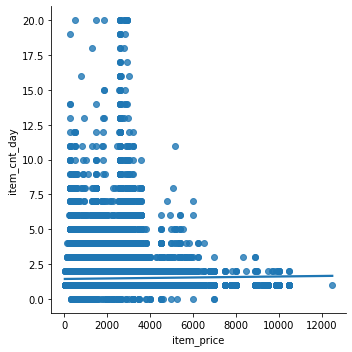

In [19]:
sns.lmplot(x='item_price', y='item_cnt_day', data = df_exploration_data)

### Training XG Boost Regressor

In [20]:
def train_xgboost(**kwargs):
    train_x = kwargs.get('train_x')
    train_y = kwargs.get('train_y')
    val_x = kwargs.get('val_x')
    val_y = kwargs.get('val_y')
    test_x = kwargs.get('test_x') if 'test_x' in kwargs.keys() else pd.DataFrame()
    perform_test_predictions = kwargs.get('perform_test_predictions')

    current = time.time()
    print('Fitting xg boost...')

    model = xgb.XGBRegressor(
                    max_depth = 11, 
                    min_child_weight=0.5, 
                    subsample = 1, 
                    eta = 0.3, 
                    num_round = 1000, 
                    seed = 1, 
                    nthread = 4,
                    verbosity=0)
    model.fit(train_x, train_y, eval_metric='rmse')

    if len(val_x)>0:
        preds = model.predict(val_x)
        # Clipping to range 0-20
        preds = np.clip(preds, 0,20)
        print('val set rmse: ', sqrt(mean_squared_error(val_y, preds)))

        if perform_test_predictions:
            preds = model.predict(test_x)
            # Clipping to range 0-20
            preds = np.clip(preds, 0,20)
            df = pd.DataFrame(preds, columns = ['item_cnt_day'])
            df['ID'] = df.index
            df = df.set_index('ID')
            print('test predictions written to file')
            end = time.time()
            diff = end - current
            print('Took ' + str(int(diff)) + ' seconds to train and predict val, test set')
            return model, df
        else:
            end = time.time()
            diff = end - current
            print('Took ' + str(int(diff)) + ' seconds to train and predict val set')
            return model, pd.DataFrame(columns = ['item_cnt_day'])
    else:
        end = time.time()
        diff = end - current
        print('Took ' + str(int(diff)) + ' seconds to train and predict val set')
        return model, pd.DataFrame(columns = ['item_cnt_day'])

In [21]:
if not os.path.exists(os.path.join('models_outputs', 'models_essentials_v02')):
    os.makedirs(os.path.join('models_outputs', 'models_essentials_v02'))

for parent_cat in tqdm(finalized_modelling_dict.keys(), desc='Training models for parent categories'):

    print('Training, Validating and Saving xg boost model for Category: %s' %(parent_cat))
    
    # Extracting parent category data
    parent_data =  finalized_modelling_dict.get(parent_cat)

    # Training xg boosting model
    model_w_price, test_predictions = train_xgboost(
                                        train_x = parent_data.get('train_x'),
                                        train_y = parent_data.get('train_y'),
                                        val_x = parent_data.get('val_x'),
                                        val_y = parent_data.get('val_y'),
                                        perform_test_predictions = False
                                    )

    # Saving trained model
    model_file_name = 'model_trained_' + str(parent_category_map.get(parent_cat))+ '_w_price.pkl'
    with open(os.path.join('models_outputs', 'models_essentials_v02', model_file_name), 'wb') as model_file:
        pickle.dump(model_w_price, model_file)

Training models for parent categories:   0%|          | 0/21 [00:00<?, ?it/s]

Training, Validating and Saving xg boost model for Category: Accessories
Fitting xg boost...
val set rmse:  0.9285475687437565
Took 11 seconds to train and predict val set


Training models for parent categories:   5%|▍         | 1/21 [00:11<03:55, 11.79s/it]

Training, Validating and Saving xg boost model for Category: Gifts
Fitting xg boost...
val set rmse:  2.7266546015941353
Took 37 seconds to train and predict val set


Training models for parent categories:  10%|▉         | 2/21 [00:50<08:41, 27.46s/it]

Training, Validating and Saving xg boost model for Category: Mac Games
Fitting xg boost...


Training models for parent categories:  14%|█▍        | 3/21 [00:51<04:41, 15.64s/it]

val set rmse:  5.960464477539063e-08
Took 1 seconds to train and predict val set
Training, Validating and Saving xg boost model for Category: Music
Fitting xg boost...
val set rmse:  0.43284926061107903
Took 70 seconds to train and predict val set


Training models for parent categories:  24%|██▍       | 5/21 [02:03<06:26, 24.16s/it]

Training, Validating and Saving xg boost model for Category: Pc
Fitting xg boost...
Took 0 seconds to train and predict val set
Training, Validating and Saving xg boost model for Category: Pc Games
Fitting xg boost...
val set rmse:  2.079459682856965
Took 64 seconds to train and predict val set


Training models for parent categories:  29%|██▊       | 6/21 [03:08<09:30, 38.05s/it]

Training, Validating and Saving xg boost model for Category: Payment Cards (Cinema, Music, Games)
Fitting xg boost...
Took 1 seconds to train and predict val set


Training models for parent categories:  33%|███▎      | 7/21 [03:10<06:09, 26.40s/it]

Training, Validating and Saving xg boost model for Category: Payment Cards
Fitting xg boost...
val set rmse:  1.455595595687405
Took 5 seconds to train and predict val set


Training models for parent categories:  38%|███▊      | 8/21 [03:17<04:19, 19.97s/it]

Training, Validating and Saving xg boost model for Category: Power Elements
Fitting xg boost...
val set rmse:  0.8771261778732267
Took 1 seconds to train and predict val set


Training models for parent categories:  43%|████▎     | 9/21 [03:19<02:52, 14.36s/it]

Training, Validating and Saving xg boost model for Category: Programs
Fitting xg boost...
val set rmse:  1.526896788048135
Took 22 seconds to train and predict val set


Training models for parent categories:  48%|████▊     | 10/21 [03:41<03:06, 16.95s/it]

Training, Validating and Saving xg boost model for Category: Service
Fitting xg boost...
val set rmse:  1.5294277967532048
Took 2 seconds to train and predict val set


Training models for parent categories:  52%|█████▏    | 11/21 [03:44<02:06, 12.60s/it]

Training, Validating and Saving xg boost model for Category: Android Games
Fitting xg boost...


Training models for parent categories:  57%|█████▋    | 12/21 [03:44<01:19,  8.86s/it]

val set rmse:  1.2815334470989654
Took 0 seconds to train and predict val set
Training, Validating and Saving xg boost model for Category: Tickets (Digit)
Fitting xg boost...
val set rmse:  0.23343268036842346
Took 1 seconds to train and predict val set


Training models for parent categories:  62%|██████▏   | 13/21 [03:46<00:52,  6.60s/it]

Training, Validating and Saving xg boost model for Category: Игры
Fitting xg boost...
val set rmse:  2.0717423275210827
Took 4 seconds to train and predict val set


Training models for parent categories:  67%|██████▋   | 14/21 [03:51<00:42,  6.07s/it]

Training, Validating and Saving xg boost model for Category: Books
Fitting xg boost...
val set rmse:  1.9254715012996633
Took 16 seconds to train and predict val set


Training models for parent categories:  71%|███████▏  | 15/21 [04:08<00:55,  9.33s/it]

Training, Validating and Saving xg boost model for Category: Cinema
Fitting xg boost...
val set rmse:  0.7092717056417793
Took 88 seconds to train and predict val set


Training models for parent categories:  76%|███████▌  | 16/21 [05:37<02:46, 33.39s/it]

Training, Validating and Saving xg boost model for Category: Clean Media (Piece)
Fitting xg boost...
Took 1 seconds to train and predict val set


Training models for parent categories:  81%|████████  | 17/21 [05:39<01:35, 23.94s/it]

Training, Validating and Saving xg boost model for Category: Clean Media (Spire)
Fitting xg boost...


Training models for parent categories:  86%|████████▌ | 18/21 [05:39<00:50, 16.91s/it]

Took 0 seconds to train and predict val set
Training, Validating and Saving xg boost model for Category: Film
Fitting xg boost...
val set rmse:  0.9529022849168058
Took 25 seconds to train and predict val set


Training models for parent categories:  90%|█████████ | 19/21 [06:05<00:39, 19.65s/it]

Training, Validating and Saving xg boost model for Category: Games
Fitting xg boost...
val set rmse:  1.8335382654907386
Took 109 seconds to train and predict val set


Training models for parent categories:  95%|█████████▌| 20/21 [07:56<00:46, 46.88s/it]

Training, Validating and Saving xg boost model for Category: Gaming Consoles
Fitting xg boost...
val set rmse:  0.46452189997643734
Took 7 seconds to train and predict val set


Training models for parent categories: 100%|██████████| 21/21 [08:04<00:00, 23.07s/it]


### Saving features dataframe

In [22]:
df_features.to_csv(os.path.join('models_outputs', 'models_essentials_v02', 'df_features.csv'), index=False)

### Saving features dataframe

In [23]:
df_xvar.to_csv(os.path.join('models_outputs', 'models_essentials_v02', 'df_xvar.csv'), index=False)

### Saving uniques

In [ ]:
with open(os.path.join('models_outputs', 'models_essentials_v02', 'uniques.pkl'), "wb") as fp:
    pickle.dump(unique_dict, fp)